<a href="https://colab.research.google.com/github/Sinem-B62/retail_demand_analysis/blob/main/01_data_guayas_preprocessing_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Retail Analysis**

## **Datenimport und Vorbereitung der Download-Funktionen**



In [1]:
!pip install -U gdown

import pandas as pd
import requests
import io


# Erstellen Sie die direkte Download-URL aus einer Datei-ID.
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Hilfsfunktion zum Laden einer CSV-Datei über eine direkte URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Löst einen Fehler aus, wenn die Anfrage fehlschlägt.
    return pd.read_csv(io.StringIO(response.text))

# Verzeichnis der Datei-IDs zur besseren Übersichtlichkeit
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))
df_items          = load_csv_from_url(make_drive_url(file_ids["items"]))
df_oil            = load_csv_from_url(make_drive_url(file_ids["oil"]))
df_stores         = load_csv_from_url(make_drive_url(file_ids["stores"]))
df_transactions   = load_csv_from_url(make_drive_url(file_ids["transactions"]))


In [2]:
import gdown

train_url = make_drive_url(file_ids["train"])


gdown.download(train_url, "train.csv", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv
From (redirected): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv&confirm=t&uuid=63d3f065-d0b6-4660-aa1e-459f09b3519b
To: /content/train.csv
100%|██████████| 5.00G/5.00G [01:09<00:00, 71.8MB/s]


'train.csv'

### Filterung nach der Region Guayas

In [3]:
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()
print("Anzahl Guayas-Stores:", len(store_ids))

Anzahl Guayas-Stores: 11


### Chunkweises Laden des großen Trainingsdatensatzes

Der Datensatz train.csv ist sehr groß, daher wird er in stückweise geladen (in Chunks), um den Arbeitsspeicher zu schonen.
Mit dem Parameter chunksize = 10**6 liest Pandas jeweils eine Million Zeilen pro Durchlauf ein.
In jeder Schleife behalten wir nur die Zeilen, deren store_nbr in der Region Guayas liegt.
Diese gefilterten Teilstücke werden in einer Liste gespeichert und später zu einem einzigen DataFrame (df_train) zusammengeführt.

In [4]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

chunk_size = 10**6
filtered_chunks = []

for chunk in pd.read_csv("train.csv", chunksize=chunk_size):
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    filtered_chunks.append(chunk_filtered)
    del chunk


Mounted at /content/drive


/tmp/ipython-input-436568586.py:9: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv("train.csv", chunksize=chunk_size):


In [5]:
df_train = pd.concat(filtered_chunks, ignore_index=True)

df_train = df_train.sample(n=300_000, random_state=42).reset_index(drop=True)

## 🏷️ Top-3-Produktfamilien identifizieren und filtern

In diesem Schritt untersuchen wir, welche Produktfamilien (z. B. „Grocery“, „Beverages“, „Cleaning“) am häufigsten vorkommen.
Dazu zählen wir, wie viele Artikel (items) pro Familie existieren, und wählen die drei größten Gruppen aus.
So erhalten wir einen Überblick über die wichtigsten Sortimente, die einen Großteil des Umsatzes ausmachen könnten.

Das Fokussieren auf die Top-Familien reduziert die Komplexität der Analyse und erlaubt es, Verkaufsdynamiken innerhalb relevanter Produktkategorien genauer zu betrachten.

In [6]:
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
top_3_families = items_per_family.head(3)


item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].unique()


df_train = df_train[df_train['item_nbr'].isin(item_ids)]


In [7]:
item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].unique()

df_train_filtered = df_train[df_train['item_nbr'].isin(item_ids)]
df_train_filtered

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
1,40318340,2015-01-31,27,804974,18.0,False
3,24252889,2014-05-23,27,207857,6.0,False
5,42964215,2015-03-15,51,1037412,1.0,False
7,90777969,2016-09-12,24,1463569,5.0,False
9,32543916,2014-10-07,32,874593,13.0,False
...,...,...,...,...,...,...
299994,111918440,2017-04-09,28,2048279,12.0,False
299995,79976124,2016-05-22,51,1926107,14.0,True
299997,5532714,2013-05-13,34,464339,7.0,NaN
299998,29608884,2014-08-24,51,422452,1.0,False


In [8]:
import os

save_dir = '/content/drive/MyDrive/Data Science Sinem/Time Series'
os.makedirs(save_dir, exist_ok=True)

# Pickle speichern (behält Datentypen exakt bei)
pickle_path = f'{save_dir}/df_train_filtered_top3.pkl'
df_train_filtered.to_pickle(pickle_path)

print(f"✅ Gefilterter Datensatz gespeichert: {len(df_train_filtered):,} Zeilen")
print(f"📁 Speicherort: {pickle_path}")


✅ Gefilterter Datensatz gespeichert: 193,124 Zeilen
📁 Speicherort: /content/drive/MyDrive/Data Science Sinem/Time Series/df_train_filtered_top3.pkl


In [9]:
csv_path = '/content/drive/MyDrive/Data Science Sinem/Time Series/df_train_filtered_top3.csv'
df_train_filtered.to_csv(csv_path, index=False)
print(f"📁 CSV-Datei gespeichert: {csv_path}")


📁 CSV-Datei gespeichert: /content/drive/MyDrive/Data Science Sinem/Time Series/df_train_filtered_top3.csv


## **🔍 Datenexploration und Bereinigung fehlender Werte**

Zunächst überprüfen wir für alle Datensätze, ob es fehlende Werte (NaN) gibt.
Diese Kontrolle ist essenziell, um Datenlücken frühzeitig zu erkennen und zu entscheiden, wie sie behandelt werden sollen.


In [10]:
print(df_items.isnull().sum())
print(df_stores.isnull().sum())
print(df_holiday_events.isnull().sum())
print(df_oil.isnull().sum())
print(df_transactions.isnull().sum())
print(df_train_filtered.isnull().sum())

item_nbr      0
family        0
class         0
perishable    0
dtype: int64
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
date           0
dcoilwtico    43
dtype: int64
date            0
store_nbr       0
transactions    0
dtype: int64
id                 0
date               0
store_nbr          0
item_nbr           0
unit_sales         0
onpromotion    35973
dtype: int64


In [11]:
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(0)

In [12]:
# Fokus auf fehlende Werte in der Spalte „onpromotion”.
df_train_filtered['onpromotion'] = df_train_filtered['onpromotion'].fillna(False).astype(bool)

/tmp/ipython-input-1348490742.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train_filtered['onpromotion'] = df_train_filtered['onpromotion'].fillna(False).astype(bool)


In [13]:
print(df_oil.isnull().sum())
print(df_train_filtered.isnull().sum())

date          0
dcoilwtico    0
dtype: int64
id             0
date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
dtype: int64


Das Feld **date** wird in einen echten Datetime-Datentyp umgewandelt.
Dadurch kann Pandas die Spalte zeitlich interpretieren, was z. B. für Sortierungen, Zeitgruppen und Rolling-Funktionen (gleitende Durchschnitte) notwendig ist.

In [14]:
df_train_filtered['date'] = pd.to_datetime(df_train_filtered['date'])

In [15]:
df_train_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193124 entries, 1 to 299999
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           193124 non-null  int64         
 1   date         193124 non-null  datetime64[ns]
 2   store_nbr    193124 non-null  int64         
 3   item_nbr     193124 non-null  int64         
 4   unit_sales   193124 non-null  float64       
 5   onpromotion  193124 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3)
memory usage: 9.0 MB


In Zeitreihenanalysen ist eine durchgehende zeitliche Struktur entscheidend.
Nur so lassen sich Trends, saisonale Muster und Lücken korrekt erkennen.
Dieser Schritt ist besonders wichtig, da Verkaufsdaten oft unregelmäßig vorliegen.

In [16]:
def fill_calendar(group):
    # group enthält die Daten für EIN (store_nbr, item_nbr)-Paar
    g = group.set_index("date").sort_index()  # Datum wird Index → Zeitreihe
    g = g.asfreq("D", fill_value=0)           # sorgt für tägliche Frequenz + füllt Lücken mit 0

    g["store_nbr"] = group["store_nbr"].iloc[0]
    g["item_nbr"] = group["item_nbr"].iloc[0]
    return g.reset_index()


In [17]:
df_train_filtered = (
    df_train_filtered
    .groupby(["store_nbr", "item_nbr"], group_keys=False)
    .apply(fill_calendar)
)


/tmp/ipython-input-2065792965.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fill_calendar)


## **Umgang mit Ausreißern**

Bei realen Verkaufsdaten treten oft Ausreißer oder fehlerhafte Werte auf – etwa durch fehlerhafte Erfassung, Rücksendungen oder außergewöhnliche Ereignisse.
Deshalb ist es wichtig, die Daten auf Unregelmäßigkeiten zu prüfen und zu bereinigen, bevor sie in eine Analyse oder ein Modell eingehen.

Zuerst werden alle Datensätze überprüft, bei denen die Verkaufsmenge (unit_sales) kleiner als 0 ist.
Solche Werte sind logisch nicht möglich (negative Verkäufe) und deuten meist auf Rückbuchungen oder Datenerfassungsfehler hin.

In [18]:
negative_sales = df_train_filtered[df_train_filtered['unit_sales'] < 0]

negative_sales.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion
1404,2017-01-30,104660668,24,321798,-1.0,False
735,2015-07-11,51126981,24,1105215,-1.0,False
0,2017-04-15,112526522,24,2011910,-8.0,False
536,2015-06-13,48880988,26,765520,-1.0,False
0,2013-04-16,4362347,27,469643,-1.0,False


In [19]:
df_train_filtered['unit_sales'] = df_train_filtered['unit_sales'].apply(lambda x: max(x, 0))

In [20]:
df_train_filtered[df_train_filtered['unit_sales'] < 0]

,date,id,store_nbr,item_nbr,unit_sales,onpromotion


###  Statistische Ausreißer mithilfe des Z-Scores erkennen.

Dieser Wert zeigt, wie stark ein Datenpunkt vom Durchschnitt abweicht.
Beispielsweise bedeutet ein Z-Score von 5, dass der Wert fünf Standardabweichungen über dem Mittelwert liegt – also auffällig hoch.

In [21]:
import numpy as np

# Negative Verkäufe säubern
df_train_filtered['unit_sales'] = df_train_filtered['unit_sales'].clip(lower=0)

# Z-Score pro (store_nbr, item_nbr) OHNE apply — stabil & schnell
grp = df_train_filtered.groupby(['store_nbr', 'item_nbr'])['unit_sales']

mu = grp.transform('mean')              # Gruppenmittel
sigma = grp.transform('std')            # Gruppen-Std
sigma = sigma.fillna(0)                 # falls Gruppe nur 1 Wert hat

# Division robust machen: σ=0 -> NaN -> später 0
z = (df_train_filtered['unit_sales'] - mu) / sigma.replace(0, np.nan)
df_train_filtered['z_score'] = z.fillna(0)

# Ausreißer markieren/ziehen (Schwelle ggf. anpassen)
outlier_threshold = 5

# Ausreißer aus df_train_filtered ziehen, nicht aus df_train
ausreisser = df_train_filtered.loc[df_train_filtered['z_score'] > outlier_threshold]

print(f"✅ Z-Score berechnet. Ausreißer > {outlier_threshold}: {len(ausreisser):,}")
print(f"🔢 Zeilen unverändert: {len(df_train_filtered):,}")

✅ Z-Score berechnet. Ausreißer > 5: 120,427
🔢 Zeilen unverändert: 17,455,672


# **⚙️ Feature-Engineering**

Feature-Engineering bedeutet, aus bestehenden Rohdaten zusätzliche, aussagekräftige Merkmale (Features) zu erstellen,
die Muster, Trends oder saisonale Effekte besser sichtbar machen.
In diesem Schritt konzentrieren wir uns auf zeitbezogene Variablen und statistische Glättung.

Zunächst wird das Datumsfeld (date) in den Datentyp datetime umgewandelt,
damit Pandas darauf zeitbasierte Operationen anwenden kann.
Anschließend zerlegen wir das Datum in vier Komponenten.

Diese neuen Spalten ermöglichen es, saisonale Muster oder wöchentliche Schwankungen in den Verkäufen zu erkennen.

In [23]:
#Datum zerlegen (zeitbezogene Features erzeugen)
df_train_filtered['date'] = pd.to_datetime(df_train_filtered['date'])


df_train_filtered['year'] = df_train_filtered['date'].dt.year
df_train_filtered['month'] = df_train_filtered['date'].dt.month
df_train_filtered['day'] = df_train_filtered['date'].dt.day
df_train_filtered['day_of_week'] = df_train_filtered['date'].dt.dayofweek # Monday=0 … Sunday=6


df_train_filtered.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,year,month,day,day_of_week
0,2013-01-17,622071,24,96995,2.0,False,7.867965,2013,1,17,3
1,2013-01-18,0,24,96995,0.0,0,-0.112399,2013,1,18,4
2,2013-01-19,0,24,96995,0.0,0,-0.112399,2013,1,19,5
3,2013-01-20,0,24,96995,0.0,0,-0.112399,2013,1,20,6
4,2013-01-21,0,24,96995,0.0,0,-0.112399,2013,1,21,0


### Gleitender Durchschnitt der Verkäufe

Um kurzfristige Verkaufstrends sichtbar zu machen, wird ein gleitender 7-Tage-Durchschnitt (unit_sales_7d_avg) berechnet.
Dazu müssen die Daten vorher chronologisch sortiert werden –
denn nur dann berücksichtigt der gleitende Durchschnitt die Verkäufe der letzten sieben aufeinanderfolgenden Tage.

Der gleitende Durchschnitt glättet kurzfristige Schwankungen und hebt Trends hervor.
Er hilft später bei der Modellierung, um stabilere Vorhersagen zu treffen und saisonale Muster besser zu erfassen.

In [24]:
df_train_filtered = df_train_filtered.sort_values(['store_nbr','item_nbr','date']).reset_index(drop=True)


df_train_filtered['unit_sales_7d_avg'] = (
    df_train_filtered.groupby(['store_nbr','item_nbr'])['unit_sales']
            .transform(lambda s: s.rolling(window=7, min_periods=1).mean())
            .astype('float32')
)

# **📊 Explorative Datenanalyse (EDA) für die Region Guayas**

In diesem Abschnitt werden die Verkaufsdaten der Region Guayas visuell untersucht, um Muster, Trends und Auffälligkeiten zu erkennen.
Ziel ist es, ein besseres Verständnis über zeitliche Entwicklungen, Saisonalität und Unterschiede zwischen Filialen zu gewinnen.

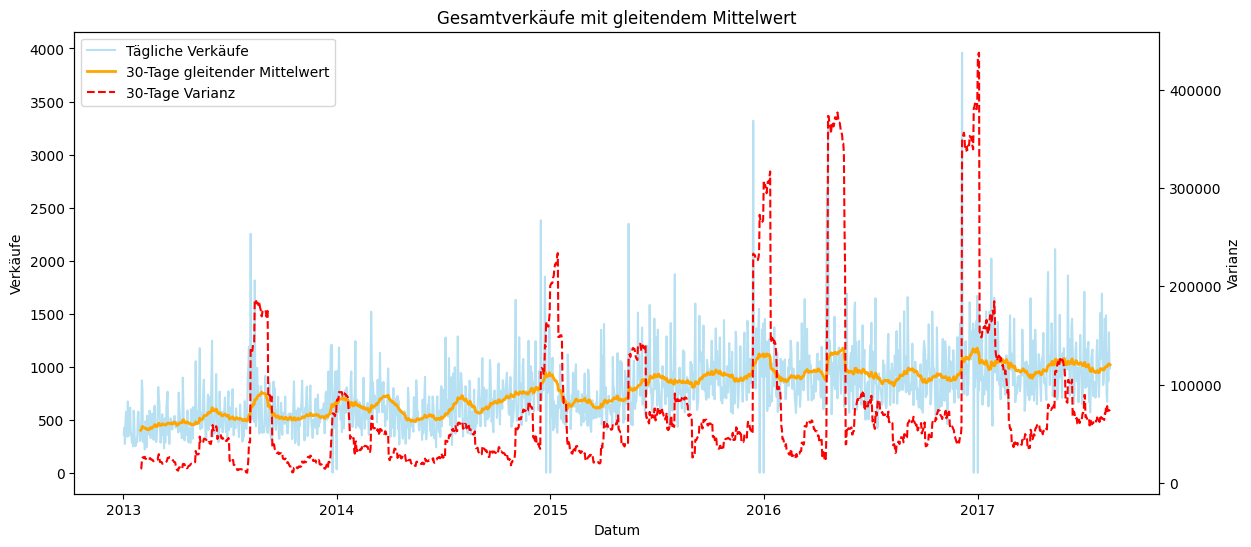

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Verkäufe nach Datum aggregieren
df_daily = df_train_filtered.groupby('date')['unit_sales'].sum().reset_index()

# Rolling Mean und Rolling Variance berechnen (z. B. 30 Tage Fenster)
window = 30  # ~1 Monat
df_daily['rolling_mean'] = df_daily['unit_sales'].rolling(window=window).mean()
df_daily['rolling_var'] = df_daily['unit_sales'].rolling(window=window).var()

# Plot erstellen
fig, ax1 = plt.subplots(figsize=(14,6))

# Original-Verkäufe (Gesamtlinie)
ax1.plot(df_daily['date'], df_daily['unit_sales'], color='skyblue', alpha=0.6, label='Tägliche Verkäufe')

# Rolling Mean (Trendlinie)
ax1.plot(df_daily['date'], df_daily['rolling_mean'], color='orange', linewidth=2, label=f'{window}-Tage gleitender Mittelwert')

# Achsenbeschriftung
ax1.set_xlabel('Datum')
ax1.set_ylabel('Verkäufe')
ax1.set_title('Gesamtverkäufe mit gleitendem Mittelwert')

# Zweite Y-Achse für Varianz
ax2 = ax1.twinx()
ax2.plot(df_daily['date'], df_daily['rolling_var'], color='red', linestyle='--', label=f'{window}-Tage Varianz')
ax2.set_ylabel('Varianz')

# Legenden kombinieren
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()



Der gleitende Mittelwert glättet kurzfristige Schwankungen und zeigt den langfristigen Trend:
Man erkennt, dass die Verkaufszahlen zwischen 2013 und 2016 stetig zunehmen, bevor sie gegen 2017 leicht zurückgehen.

Die Varianz (rote Linie) gibt Auskunft über die Stabilität der Verkäufe:
Hohe Ausschläge der Varianz deuten auf unregelmäßige Verkaufsphasen hin (z. B. Aktionen oder Feiertage).
Eine geringe Varianz zeigt hingegen stabile Verkaufsperioden.

Fazit: Zwischen 2015 und 2016 kam es zu einer deutlichen Zunahme und höheren Schwankungen — ein Zeichen für Wachstum, aber auch Marktbewegung.

/tmp/ipython-input-322361275.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='unit_sales', data=df_monthly, palette='viridis')


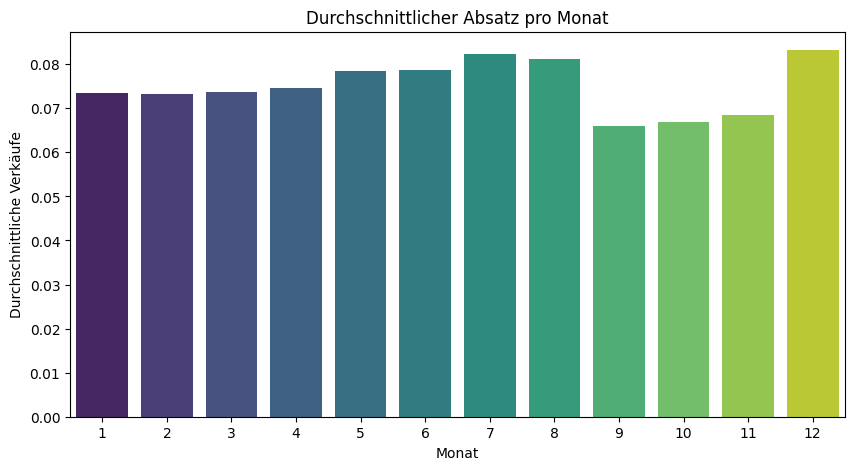

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Monatsdurchschnitt berechnen
df_monthly = df_train_filtered.groupby('month')['unit_sales'].mean().reset_index()

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x='month', y='unit_sales', data=df_monthly, palette='viridis')
plt.title('Durchschnittlicher Absatz pro Monat')
plt.xlabel('Monat')
plt.ylabel('Durchschnittliche Verkäufe')
plt.show()


Die höchsten Verkäufe finden in den Monaten Juli, August und Dezember statt.

Diese Monate sind typisch für Ferienzeiten und Feiertage, in denen Konsum und Nachfrage steigen.

Dagegen zeigen Monate wie Februar oder November geringere Verkaufsaktivität.

Fazit: Es bestehen deutliche saisonale Verkaufsmuster, die bei Prognosen unbedingt berücksichtigt werden sollten.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


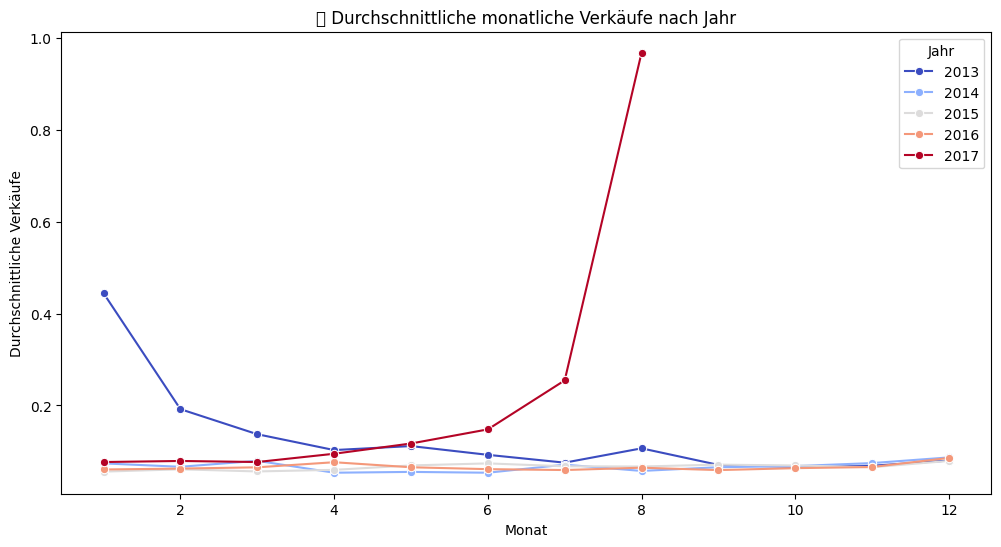

In [27]:
df_monthly_trend = (
    df_train_filtered.groupby(['year', 'month'])['unit_sales']
    .mean()
    .reset_index()
)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=df_monthly_trend,
    x='month',
    y='unit_sales',
    hue='year',
    palette='coolwarm',
    marker='o'
)
plt.title('📅 Durchschnittliche monatliche Verkäufe nach Jahr')
plt.xlabel('Monat')
plt.ylabel('Durchschnittliche Verkäufe')
plt.legend(title='Jahr')
plt.show()


Die Jahre 2015 und 2016 zeigen eine klare Wachstumsphase mit stabileren Verkäufen.

Im Jahr 2017 ist ein deutlicher Anstieg gegen Ende des Jahres zu erkennen — möglicherweise aufgrund besonderer Ereignisse oder Aktionen.

Frühere Jahre (2013–2014) haben geringere Verkaufswerte, was auf eine Marktexpansion hindeuten kann.

Fazit: Über die Jahre sind steigende Verkaufsniveaus erkennbar, was auf eine positive wirtschaftliche Entwicklung in Guayas schließen lässt.

/tmp/ipython-input-2351863864.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='rolling_mean', data=df_monthly_rolling_mean, palette='viridis')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


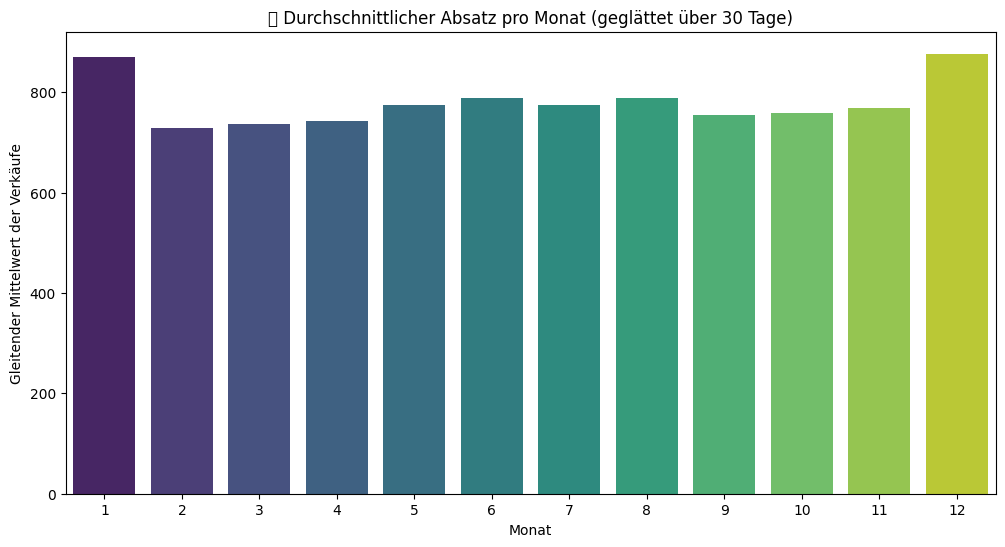

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tägliche Umsätze aggregieren und einen neuen DataFrame df_daily erstellen
df_daily = df_train_filtered.groupby('date')['unit_sales'].sum().reset_index()

# Monatsspalte zu df_daily hinzufügen
df_daily['month'] = df_daily['date'].dt.month

# Rolling Mean über 30 Tage
df_daily['rolling_mean'] = df_daily['unit_sales'].rolling(window=30).mean()

# Berechnet den durchschnittlichen gleitenden Mittelwert pro Monat
df_monthly_rolling_mean = df_daily.groupby('month')['rolling_mean'].mean().reset_index()


plt.figure(figsize=(12,6))
# Verwenden Sie statt eines Liniendiagramms ein Balkendiagramm, um die Kategorien auf der x-Achse besser darzustellen.
sns.barplot(x='month', y='rolling_mean', data=df_monthly_rolling_mean, palette='viridis')

plt.title('📈 Durchschnittlicher Absatz pro Monat (geglättet über 30 Tage)')
plt.xlabel('Monat')
plt.ylabel('Gleitender Mittelwert der Verkäufe')
plt.show()

Die Kurve zeigt, dass die Verkäufe im Jahresverlauf nicht konstant, sondern leicht zyklisch verlaufen.

Gegen Ende des Jahres steigt der gleitende Mittelwert wieder an – typisch für Weihnachts- und Festtagssaisons.

Fazit: Der Trend bestätigt die saisonalen Verkaufsspitzen, die bereits im Monatsvergleich sichtbar wurden.

In [29]:
df_store_year = (
    df_train_filtered.groupby(['year', 'store_nbr'])['unit_sales']
    .sum()
    .reset_index()
)

df_store_year.head()


# Top 5 Stores insgesamt
top_stores = (
    df_store_year.groupby('store_nbr')['unit_sales']
    .sum()
    .nlargest()
    .index
)

print("Top Stores insgesamt:", list(top_stores))

Top Stores insgesamt: [51, 24, 28, 34, 27]


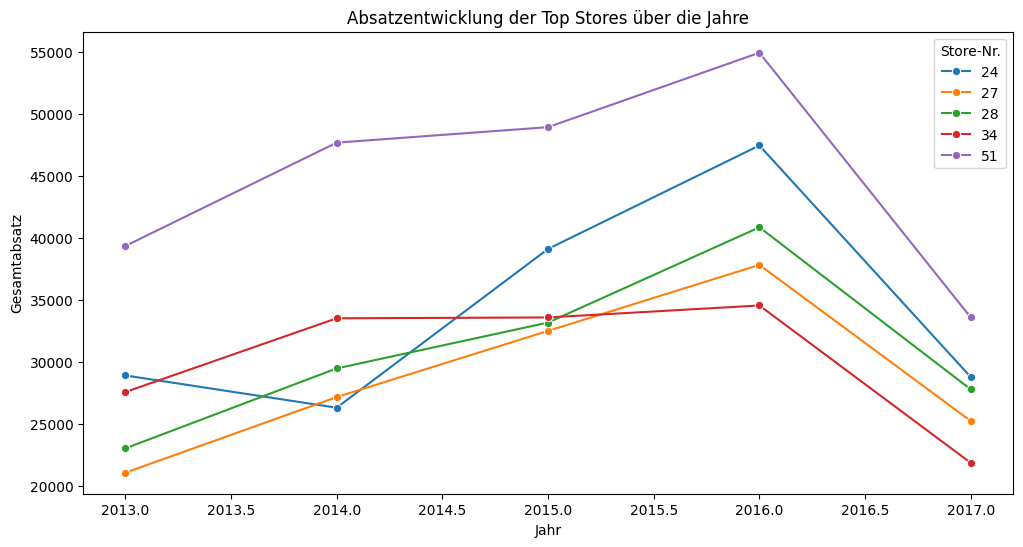

In [30]:
plt.figure(figsize=(12,6))
sns.lineplot(
    data=df_store_year[df_store_year['store_nbr'].isin(top_stores)],
    x='year',
    y='unit_sales',
    hue='store_nbr',
    marker='o',
    palette='tab10'
)
plt.title('Absatzentwicklung der Top Stores über die Jahre')
plt.xlabel('Jahr')
plt.ylabel('Gesamtabsatz')
plt.legend(title='Store-Nr.')
plt.show()


Besonders Store Nr. 51 weist die höchsten Verkaufszahlen auf und dominiert den Markt in der Region.

Alle Stores zeigen ähnliche Muster: stetiger Anstieg bis 2016, danach ein leichter Rückgang im Jahr 2017.

Das kann auf regionale Marktveränderungen oder sinkende Nachfrage hindeuten.

Fazit: Die Top-Filialen treiben den Gesamtabsatz maßgeblich an, wobei Store 51 eine führende Rolle spielt.

In [31]:
# Einheitliche Schreibweise erzwingen (alles als String)
df_train_filtered['onpromotion'] = df_train_filtered['onpromotion'].astype(str)

# Alle Varianten in True/False umwandeln
df_train_filtered['onpromotion'] = df_train_filtered['onpromotion'].replace({
    'True': True,
    'False': False,
    '0': False,
    '1': True
})

# Sicherstellen, dass der Typ boolean ist
df_train_filtered['onpromotion'] = df_train_filtered['onpromotion'].astype(bool)

# Überprüfen
print(df_train_filtered['onpromotion'].dtype)
print(df_train_filtered['onpromotion'].value_counts())


/tmp/ipython-input-146590735.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train_filtered['onpromotion'] = df_train_filtered['onpromotion'].replace({


bool
onpromotion
False    17446670
True         9002
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


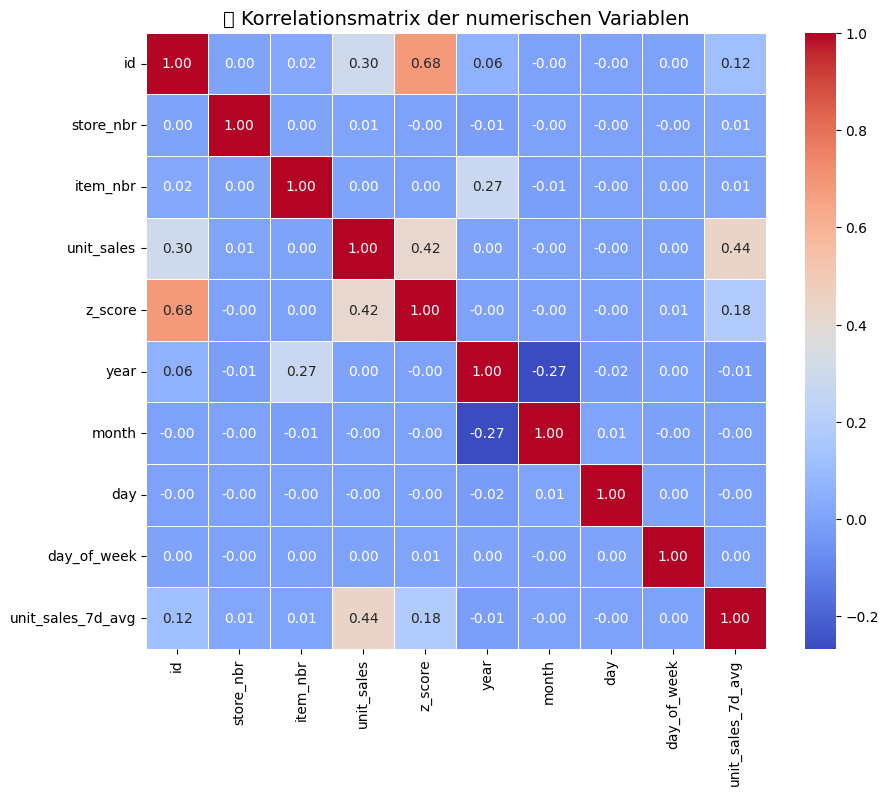

📈 Korrelation mit den Verkaufszahlen:
unit_sales           1.000000
unit_sales_7d_avg    0.437648
z_score              0.418832
id                   0.301980
store_nbr            0.005540
item_nbr             0.003362
day_of_week          0.003062
year                 0.001016
month               -0.000057
day                 -0.001630
Name: unit_sales, dtype: float64


In [32]:

# Nur numerische Spalten auswählen
corr = df_train_filtered.select_dtypes(include=['number']).corr()

# Plotten
plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5
)
plt.title("🔗 Korrelationsmatrix der numerischen Variablen", fontsize=14)
plt.show()

corr_target = corr['unit_sales'].sort_values(ascending=False)
print("📈 Korrelation mit den Verkaufszahlen:")
print(corr_target)



unit_sales korreliert am stärksten mit dem 7-Tage-Durchschnitt (unit_sales_7d_avg), was logisch ist – kurzfristige Trends spiegeln sich in den Verkäufen wider.

Die anderen Variablen (z. B. Monat, Wochentag, Jahr) zeigen nur geringe Korrelationen, was bedeutet, dass sie eher als saisonale Einflussfaktoren wirken und nicht direkt lineare Beziehungen aufweisen.

Fazit: Die Datenstruktur ist nicht stark linear, was typisch für Zeitreihen ist – zukünftige Analysen sollten daher auf nichtlineare Modelle (z. B. XGBoost, LSTM) setzen.

#**✅ Gesamtfazit zur EDA:**
Die Region Guayas zeigt eine positive Verkaufsentwicklung mit klaren saisonalen Mustern und einem starken Einfluss einzelner Filialen.
Zudem bestätigen die gleitenden Mittelwerte und Varianzanalysen, dass 2015–2016 wirtschaftlich starke Jahre waren, während 2017 leichte Rückgänge aufweist.

# **👩‍💻Finaler Datenexport nach Bereinigung**

In [33]:
import os

save_dir = '/content/drive/MyDrive/Data Science Sinem/Time Series'
os.makedirs(save_dir, exist_ok=True)

# finaler Name, damit du ihn leicht unterscheiden kannst
pickle_path_final = f'{save_dir}/df_train_filtered_top3_final.pkl'
csv_path_final = f'{save_dir}/df_train_filtered_top3_final.csv'

# Pickle speichern
df_train_filtered.to_pickle(pickle_path_final)

# CSV speichern
df_train_filtered.to_csv(csv_path_final, index=False)

print(f"✅ Finaler Datensatz gespeichert: {len(df_train_filtered):,} Zeilen, {len(df_train_filtered.columns)} Spalten")
print(f"📁 Pickle: {pickle_path_final}")
print(f"📁 CSV:    {csv_path_final}")


✅ Finaler Datensatz gespeichert: 17,455,672 Zeilen, 12 Spalten
📁 Pickle: /content/drive/MyDrive/Data Science Sinem/Time Series/df_train_filtered_top3_final.pkl
📁 CSV:    /content/drive/MyDrive/Data Science Sinem/Time Series/df_train_filtered_top3_final.csv
